<a href="https://colab.research.google.com/github/viditkhemka63/Predicting-tags-for-StackOverflow/blob/master/Predicting_tags_for_StackOverflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting tags for stackoverflow 
![](https://stackoverflow.blog/wp-content/uploads/2018/05/SO_Teams.png)
<br>
<br>

<!-- ![](https://i.imgur.com/sWyuy4Y.jpg) -->

# Downloading Data from Kaggle

In [0]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vidit64","key":"97e40619934731fe29f37d3ed18dd5e6"}'}

In [0]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [0]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
 ! kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
new-york-state/nys-environmental-remediation-sites          NYS Environmental Remediation Sites                   3MB  2019-07-30 08:11:31           1226  
new-york-city/new-york-city-current-job-postings            New York City Current Job Postings                    3MB  2019-07-28 22:04:53           4748  
google/google-landmarks-dataset                             Google-Landmarks Dataset                            107MB  2019-07-29 12:00:28           9906  
AnalyzeBoston/crimes-in-boston                              Crimes in Boston                                     10MB  2018-09-04 17:56:03           4974  
jealousleopard/goodreadsbooks                               Good

In [6]:
!kaggle datasets download 'stackoverflow/stacksample'

100% 1.14G/1.15G [00:16<00:00, 80.2MB/s]
100% 1.15G/1.15G [00:16<00:00, 72.5MB/s]


In [7]:
!ls

kaggle.json  sample_data  stacksample.zip


In [8]:
!unzip stacksample.zip
!ls 

Archive:  stacksample.zip
  inflating: Answers.csv             
  inflating: Questions.csv           
  inflating: Tags.csv                
Answers.csv  kaggle.json  Questions.csv  sample_data  stacksample.zip  Tags.csv


## Import libs

In [0]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import warnings

import pickle
import time

import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud

from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss
from sklearn.cluster import KMeans


import logging

from scipy.sparse import hstack

warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline

In [12]:
df = pd.read_csv("Questions.csv", encoding="ISO-8859-1")
df.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [13]:
tags = pd.read_csv("Tags.csv", encoding="ISO-8859-1", dtype={'Tag': str})
tags.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [0]:
tags['Tag'] = tags['Tag'].astype(str)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
Id              1264216 non-null int64
OwnerUserId     1249762 non-null float64
CreationDate    1264216 non-null object
ClosedDate      55959 non-null object
Score           1264216 non-null int64
Title           1264216 non-null object
Body            1264216 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


In [18]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
Id     int64
Tag    object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


In [15]:
grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))
grouped_tags.head()

Id
80                            flex actionscript-3 air
90       svn tortoisesvn branch branching-and-merging
120                               sql asp.net sitemap
180    algorithm language-agnostic colors color-space
260           c# .net scripting compiler-construction
Name: Tag, dtype: object

In [16]:
grouped_tags.reset_index()
grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})
grouped_tags_final.head()

,Id,Tags
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction


In [0]:
df.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)

In [20]:
df = df.merge(grouped_tags_final, on='Id')
df.head()

,Id,Score,Title,Body,Tags
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [0]:
new_df = df[df['Score']>5]

# Cleaning Data

Text(0.5, 1.0, 'Ratio of missing values per columns')

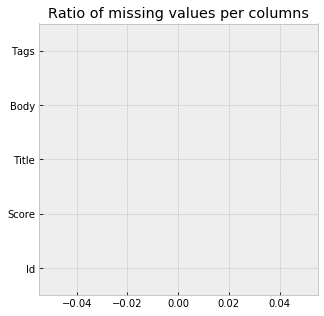

In [22]:
plt.figure(figsize=(5, 5))
new_df.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [23]:
print('Dupplicate entries: {}'.format(new_df.duplicated().sum()))
new_df.drop_duplicates(inplace = True)

Dupplicate entries: 0


This is a very good dataset since there are no missing valeus or dupplicate values.



# Preprocessing Tags

In [0]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: x.split())


In [30]:
all_tags = [item for sublist in new_df['Tags'].values for item in sublist]
print("Total no. of tags in dataset  {}".format( len(all_tags) ) )

Total no. of tags in dataset  224129


Now find total number of unique tags in dataset

In [31]:
my_set = set(all_tags)
unique_tags = list(my_set)
print("Total no. of unique tags are {}".format(len(unique_tags)))

Total no. of unique tags are 14883


Now find most common tags 

# Analyzing Text

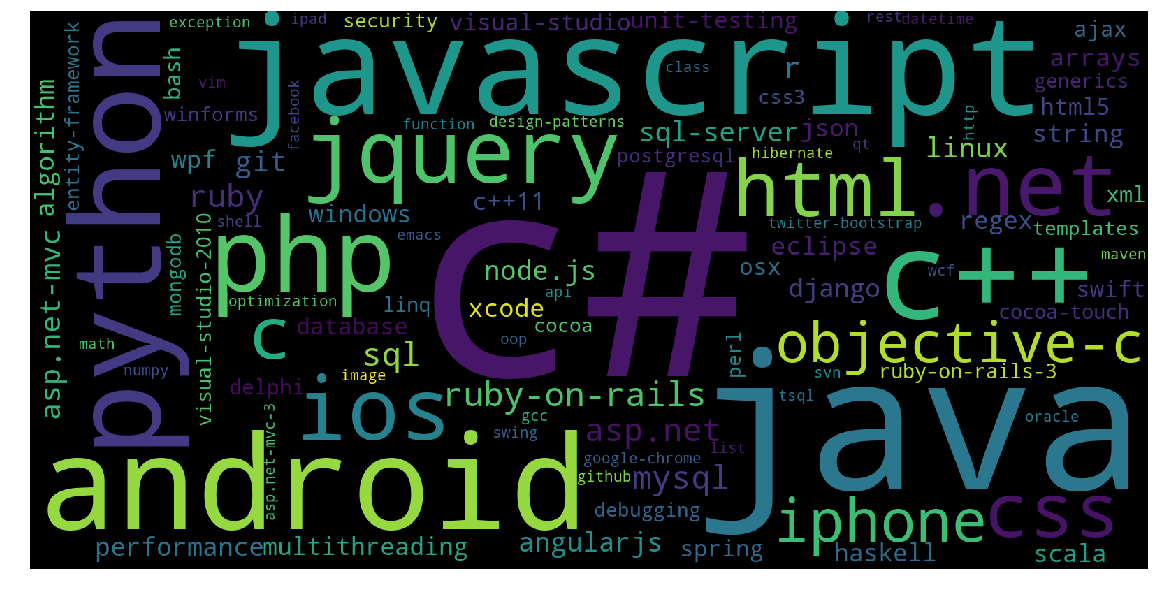

In [57]:
flat_list = [item for sublist in new_df['Tags'].values for item in sublist]

keywords = nltk.FreqDist(flat_list)

keywords = nltk.FreqDist(keywords)

frequencies_words = keywords.most_common(100)
tags_features = [word[0] for word in frequencies_words]
tags_counts = [ word[1] for word in frequencies_words ]

result = dict(zip(tags_features, tags_counts))
tup = dict(result.items())

# print('Following are most common tags')
# print(tags_features)

wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()

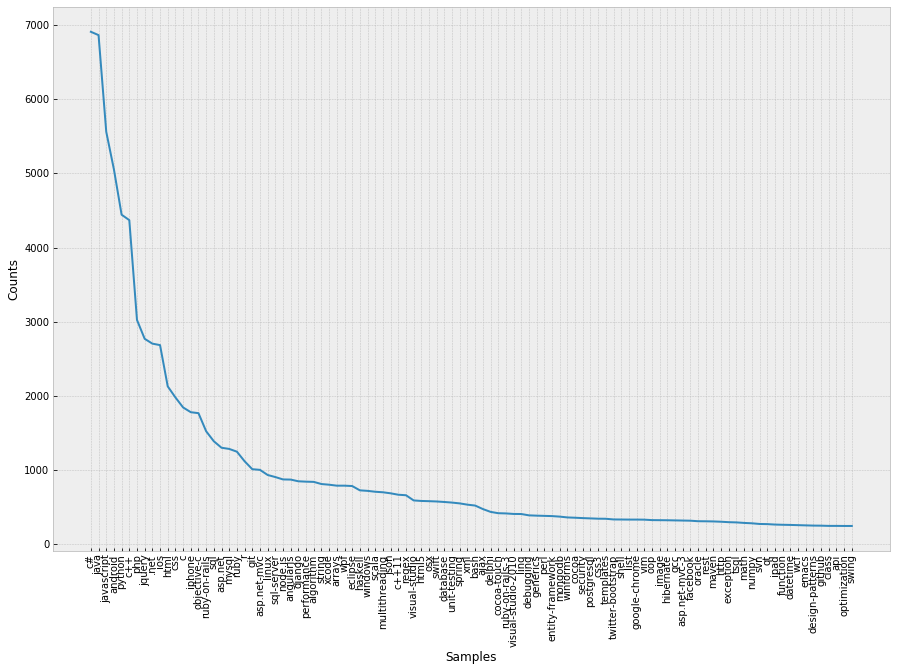

In [34]:
fig, ax = plt.subplots(figsize=(15, 10))
keywords.plot(100, cumulative=False)

This figure shows that their is a exponentional decrease in tags counts  

In [0]:
new_df['Count'] = new_df['Tags'].apply(lambda x: len(x))

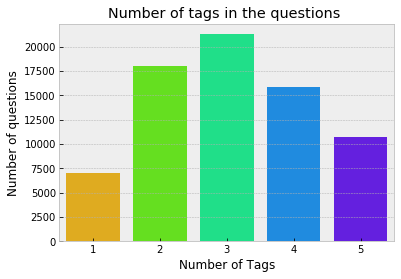

In [41]:
sns.countplot(x='Count', data= new_df, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

Now we replace all tags for a quesition  by most common tags. 

In [0]:
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

In [0]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: most_common(x))
new_df['Tags'] = new_df['Tags'].apply(lambda x: x if len(x)>0 else None)

In [61]:
print('Shape of dataset before removing Nan values {}'.format(new_df.shape))

new_df.dropna(subset=['Tags'], inplace=True)
print('Shape of dataset after removing Nan values {}'.format(new_df.shape))

Shape of dataset before removing Nan values (72950, 6)
Shape of dataset after removing Nan values (63167, 6)


# Preprocessing Body text

In [0]:
new_df['Body'] = new_df['Body'].apply(lambda x: BeautifulSoup(x).get_text()) 

In [0]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text


In [0]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_text(x)) 

In [0]:
token=ToktokTokenizer()
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [0]:
def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

In [0]:
def clean_punct(text): 
    words=token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    for w in words:
        if w in tags_features:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))
  
    filtered_list = strip_list_noempty(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))

In [0]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_punct(x)) 

In [69]:
print('test a sample element from Body')
print( new_df['Body'][2] )

test a sample element from Body
has anyone got experience creating sql-based asp.net site-map providers i have got the default xml file websitemap working properly with my menu and sitemappath controls but i will need a way for the users of my site to create and modify pages dynamically i need to tie page viewing permissions into the standard asp.net membership system as well


**Applying lemitization to Body column**

In [71]:
 nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
lemma=WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [0]:
def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def stopWordsRemove(text):
    
    stop_words = set(stopwords.words("english"))
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if not w in stop_words]
    
    return ' '.join(map(str, filtered))

In [0]:
nltk.download('wordnet')
new_df['Body'] = new_df['Body'].apply(lambda x: lemitizeWords(x)) 
new_df['Body'] = new_df['Body'].apply(lambda x: stopWordsRemove(x)) 

# Preprocessing Title text

In [0]:
new_df['Title'] = new_df['Title'].apply(lambda x: str(x))
new_df['Title'] = new_df['Title'].apply(lambda x: clean_text(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: clean_punct(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: lemitizeWords(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: stopWordsRemove(x)) 

# Exploratory data analysis ( EDA )

![](https://phhp-faculty-cantrell.sites.medinfo.ufl.edu/files/2012/07/images-mod1-big-picture-eda.gif)
<br>
exploratory data analysis (EDA) is an approach to analyzing data sets to summarize their main characteristics, often with visual methods. A statistical model can be used or not, but primarily EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing task.
<br>
<br>

Here I'll just use some LDA to see if shows any paterns in words and the main topics.

In [0]:
no_topics = 20
text = new_df['Body']
vectorizer_train = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                       max_features=1000)

In [0]:
TF_IDF_matrix = vectorizer_train.fit_transform(text)
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50,random_state=11).fit(TF_IDF_matrix)

In [81]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("--------------------------------------------")
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("--------------------------------------------")
        

no_top_words = 10
display_topics(lda, vectorizer_train.get_feature_names(), no_top_words)

--------------------------------------------
Topic 0:
div function var html script class page jquery id input
--------------------------------------------
--------------------------------------------
Topic 1:
use app ios would find xcode like know android application
--------------------------------------------
--------------------------------------------
Topic 2:
00 scala font 09 01 02 tab utf-8 socket constant
--------------------------------------------
--------------------------------------------
Topic 3:
array list number data value would use like way function
--------------------------------------------
--------------------------------------------
Topic 4:
android width color height div background scroll style image top
--------------------------------------------
--------------------------------------------
Topic 5:
import python module modules def random filter statement docs 22
--------------------------------------------
--------------------------------------------
Topic 6:
b

It is not a good result


# Classical classifiers

##  Data preparation

Now our data is almost ready to be put into a classifier. I just need to:



*   Binarize the tags
*   Use a TFIDF for body and Title The parameters in the TFIDF are very important for the performance of our tags since we don't want him to delete words like c# or.net. To do that we need to use the following pattern : token_pattern=r"(?u)\S\S+"



In [0]:
X1 = new_df['Body']
X2 = new_df['Title']
y = new_df['Tags']

In [0]:
multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)

In [0]:
vectorizer_X1 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

vectorizer_X2 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

In [0]:
X1_tfidf = vectorizer_X1.fit_transform(X1)
X2_tfidf = vectorizer_X2.fit_transform(X2)

In [0]:
hX_train, hX_test, hy_train, hy_test = train_test_split(X2_tfidf, y_bin, test_size = 0.2, random_state = 0) # Do 80/20 split

In [0]:
X_tfidf = hstack([X1_tfidf,X2_tfidf])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.2, random_state = 0) # Do 80/20 split


# One vs Rest

To evaluate our models, I'll use the jacard score since it's the best fitted for multi label classification.


In [0]:
def avg_jacard(y_true,y_pred):
    '''
    see https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics
    '''
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    
    return jacard.mean()*100

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Jacard score: {}".format(avg_jacard(y_test, y_pred)))
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)*100))
    

In [91]:
dummy = DummyClassifier()
sgd = SGDClassifier()
lr = LogisticRegression()
mn = MultinomialNB()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()

for classifier in [dummy, sgd, lr, mn, svc, perceptron, pac]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print_score(y_pred, classifier)
    print('Accuracy score: {}'.format(accuracy_score( y_test, y_pred )))

Clf:  DummyClassifier
Jacard score: 2.619993039693847
Hamming loss: 3.0323729618489788
---
Accuracy score: 0.005857210701282254
Clf:  SGDClassifier
Jacard score: 47.610944013508515
Hamming loss: 0.956624980212126
---
Accuracy score: 0.3493747031818901
Clf:  LogisticRegression
Jacard score: 48.3590575695214
Hamming loss: 0.9707139464935887
---
Accuracy score: 0.34636694633528575
Clf:  MultinomialNB
Jacard score: 40.30181219234568
Hamming loss: 1.1750039575747981
---
Accuracy score: 0.2604084217191705
Clf:  LinearSVC
Jacard score: 52.356208115666725
Hamming loss: 0.9552794047807505
---
Accuracy score: 0.3714579705556435
Clf:  Perceptron
Jacard score: 46.88522530536143
Hamming loss: 1.4487098306157986
---
Accuracy score: 0.2638119360455913
Clf:  PassiveAggressiveClassifier
Jacard score: 49.116330084352875
Hamming loss: 1.2503561817318347
---
Accuracy score: 0.3021212600918157


## MLP Classifier

![](https://rasbt.github.io/mlxtend/user_guide/classifier/MultiLayerPerceptron_files/MultiLayerPerceptron_23_0.png)

In [92]:
mlpc = MLPClassifier()
mlpc.fit(X_train, y_train)

y_pred = mlpc.predict(X_test)

print_score(y_pred, mlpc)
print('Accuracy score: {}'.format(accuracy_score( y_test, y_pred )))

Clf:  MLPClassifier
Jacard score: 48.5543450402165
Hamming loss: 1.3370270698116196
---
Accuracy score: 0.2823333861009973


## Random Forest
![](https://miro.medium.com/max/1184/1*i0o8mjFfCn-uD79-F1Cqkw.png)

In [94]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print_score(y_pred, rfc)
print('Accuracy score: {}'.format(accuracy_score( y_test, y_pred )))

Clf:  RandomForestClassifier
Jacard score: 42.31333438868661
Hamming loss: 1.0654582871616274
Accuracy score: 0.3091657432325471


# GridSearch CV on the best classifier

![](https://raw.githubusercontent.com/nslatysheva/data_science_blogging/master/expanding_ML_toolkit/expanding_toolkit.jpg)

In [0]:
param_grid = {'estimator__C':[1,10,100,1000]
              }

In [115]:
svc = OneVsRestClassifier(LinearSVC())
CV_svc = model_selection.GridSearchCV(estimator=svc, param_grid=param_grid, cv= 5, verbose=10, scoring=make_scorer(avg_jacard,greater_is_better=True))
CV_svc.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... estimator__C=1, score=52.335, total=  17.6s
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.6s remaining:    0.0s


[CV] ..................... estimator__C=1, score=52.115, total=  17.3s
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   35.0s remaining:    0.0s


[CV] ..................... estimator__C=1, score=51.207, total=  17.3s
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   52.3s remaining:    0.0s


[CV] ..................... estimator__C=1, score=50.967, total=  16.7s
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.2min remaining:    0.0s


[CV] ..................... estimator__C=1, score=51.546, total=  17.5s
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s


[CV] .................... estimator__C=10, score=48.658, total=  55.1s
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.4min remaining:    0.0s


[CV] .................... estimator__C=10, score=48.319, total=  52.0s
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.2min remaining:    0.0s


[CV] .................... estimator__C=10, score=47.885, total=  53.7s
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  4.1min remaining:    0.0s


[CV] .................... estimator__C=10, score=46.934, total=  55.2s
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  5.0min remaining:    0.0s


[CV] .................... estimator__C=10, score=47.594, total=  55.0s
[CV] estimator__C=100 ................................................
[CV] ................... estimator__C=100, score=44.896, total= 1.4min
[CV] estimator__C=100 ................................................
[CV] ................... estimator__C=100, score=44.752, total= 1.4min
[CV] estimator__C=100 ................................................
[CV] ................... estimator__C=100, score=44.271, total= 1.4min
[CV] estimator__C=100 ................................................
[CV] ................... estimator__C=100, score=43.613, total= 1.3min
[CV] estimator__C=100 ................................................
[CV] ................... estimator__C=100, score=44.427, total= 1.4min
[CV] estimator__C=1000 ...............................................
[CV] .................. estimator__C=1000, score=41.591, total= 1.5min
[CV] estimator__C=1000 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 20.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=OneVsRestClassifier(estimator=LinearSVC(C=1.0,
                                                               class_weight=None,
                                                               dual=True,
                                                               fit_intercept=True,
                                                               intercept_scaling=1,
                                                               loss='squared_hinge',
                                                               max_iter=1000,
                                                               multi_class='ovr',
                                                               penalty='l2',
                                                               random_state=None,
                                                               tol=0.0001,
                                                               verbose=0),
 

In [116]:
CV_svc.best_params_

{'estimator__C': 1}

In [117]:
best_model = CV_svc.best_estimator_

y_pred = best_model.predict(X_test)

print_score(y_pred, best_model)
print('Accuracy score: {}'.format(accuracy_score( y_test, y_pred )))

Clf:  OneVsRestClassifier
Jacard score: 52.356208115666725
Hamming loss: 0.9552794047807505
Accuracy score: 0.3714579705556435


##  Confusion matrix

In [118]:
for i in range(y_train.shape[1]):
    print(multilabel_binarizer.classes_[i])
    print(confusion_matrix(y_test[:,i], y_pred[:,i]))
    print("")

.net
[[12033    54]
 [  447   100]]

ajax
[[12526    15]
 [   55    38]]

algorithm
[[12445    21]
 [   87    81]]

android
[[11528    40]
 [  194   872]]

angularjs
[[12443     7]
 [   49   135]]

api
[[12567    14]
 [   45     8]]

arrays
[[12405    55]
 [  103    71]]

asp.net
[[12346    30]
 [  166    92]]

asp.net-mvc
[[12402    41]
 [   99    92]]

asp.net-mvc-3
[[12566    11]
 [   44    13]]

bash
[[12520     7]
 [   46    61]]

c
[[12220    58]
 [  203   153]]

c#
[[11060   175]
 [  618   781]]

c++
[[11674    91]
 [  260   609]]

c++11
[[12453    31]
 [  103    47]]

class
[[12574    12]
 [   45     3]]

cocoa
[[12553     4]
 [   69     8]]

cocoa-touch
[[12530    10]
 [   90     4]]

css
[[12186    74]
 [  123   251]]

css3
[[12561    13]
 [   45    15]]

database
[[12503    29]
 [   84    18]]

datetime
[[12571    17]
 [   36    10]]

debugging
[[12523    27]
 [   50    34]]

delphi
[[12542     2]
 [   39    51]]

design-patterns
[[12573    11]
 [   36    14]]

django
[[1246

In [0]:
for i in range(y_train.shape[1]):
    print(multilabel_binarizer.classes_[i])
    print(confusion_matrix(y_test[:,i], y_pred[:,i]))
    print("")

In [0]:
def print_top10(feature_names, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("--------------------------------------------")
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))
        print("--------------------------------------------")

In [0]:
feature_names = vectorizer_X1.get_feature_names() + vectorizer_X2.get_feature_names()

In [121]:
print_top10(feature_names, best_model, multilabel_binarizer.classes_)

--------------------------------------------
.net: determine finally sender windows mouse assembly microsoft consolewriteline .net .net
--------------------------------------------
--------------------------------------------
ajax: much 10 img request web items security load ajax ajax
--------------------------------------------
--------------------------------------------
algorithm: log input additional stick give although diff problem algorithm algorithm
--------------------------------------------
--------------------------------------------
android: webview eandroidruntime linearlayout fragment edittext intent textview activity android android
--------------------------------------------
--------------------------------------------
angularjs: resource factory integrate token config directive controller scope angular angularjs
--------------------------------------------
--------------------------------------------
api: virtual border interface retrieve deal webview docs dependency 